In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
from pyomo.environ import *
from optimization_utils import *
from data_processing_utils import get_ramps_per_segment, get_lanes_per_segment
from param_loader import METANET_Params
from simulation_utils import *

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os

def perturb_and_plot_mape(base_params, rho_hat, q_hat, v_hat, num_lanes_array, plotting = False):
    params = base_params.get_params()
    results = {}
    step = 0.001
    perturb_range = np.arange(-0.1, 0.1 + step, step)
    os.makedirs("perturb-results", exist_ok=True)

    # Baseline smoothed boundary conditions
    downstream_density_base = smooth_inflow(rho_hat[:, -1]) / num_lanes_array[-1]
    data_inflow_base = smooth_inflow(q_hat[:, 0])

    for key, values in list(params.items()) + [("downstream_density", downstream_density_base), ("data_inflow", data_inflow_base)]:
        # Only perturb calibrated parameters + boundary conditions
        if key not in ['eta_high', 'K', 'tau', 'p_crit', 'v_free', 'a', 'downstream_density', 'data_inflow']:
            continue

        values = np.array(values, dtype=float)
        mape_list = []

        print(f"\n=== Perturbing {key} ===")

        # Loop over perturbation levels
        for pct in perturb_range:
            perturbed_params = {k: np.array(v, dtype=float).copy() for k, v in params.items()}
            downstream_density = downstream_density_base.copy()
            data_inflow = data_inflow_base.copy()

            if key in params:
                # Perturb model parameter
                perturbed_params[key] = values * (1 + pct)
            elif key == "downstream_density":
                downstream_density = downstream_density * (1 + pct)
            elif key == "data_inflow":
                data_inflow = data_inflow * (1 + pct)

            v_sim = metanet_sim_fn(
                perturbed_params,
                rho_hat,
                q_hat,
                num_lanes_array,
                data_inflow=data_inflow,
                downstream_density=downstream_density
            )

            # Compute MAPE between simulated and observed velocities
            mape_res = mape(v_hat[:, 1:-1], v_sim[:-1, :])
            mape_list.append(mape_res)

        results[key] = np.array(mape_list)

        # Plotting
        if plotting:
            plt.figure(figsize=(6, 4))
            plt.plot(perturb_range * 100, results[key], linewidth=2)
            plt.title(f"Effect of ±10% perturbation on {key}")
            plt.xlabel("Perturbation (%)")
            plt.ylabel("MAPE (%)")
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.axvline(0, color='black', linestyle=':', linewidth=1)
            plt.tight_layout()
            
            plt.savefig(f"perturb-results/{key}_perturb.png")
            plt.show()

    return results


def metanet_sim_fn(perturbed_params, rho_hat, q_hat, num_lanes_array, data_inflow=None, downstream_density=None):
    scaled_rho_hat = rho_hat[:, 1:-1] / np.array(num_lanes_array)

    # Default to baseline if not overridden
    if data_inflow is None:
        data_inflow = smooth_inflow(q_hat[:, 0])
    if downstream_density is None:
        downstream_density = smooth_inflow(rho_hat[:, -1]) / num_lanes_array[-1]
    
    init_traffic_state = (scaled_rho_hat[0, :], v_hat[0, 1:-1], data_inflow[0], 0)
    rho_sim, v_sim, _, _ = run_metanet_sim(
        T=T,
        l=l,
        init_traffic_state=init_traffic_state,
        demand=data_inflow,
        downstream_density=downstream_density,
        params=perturbed_params,
        vsl_speeds=None,
        lanes={i: num_lanes_array[i] for i in range(num_calibrated_segments)},
        plotting=True,
        real_data=True,
    )
    return v_sim


In [7]:
# Load parameter files
num_calibrated_segments = 14
RESULTS_DIR = "calibration_results"
params = METANET_Params(path=RESULTS_DIR, num_segments=num_calibrated_segments)
rho_hat = np.load("data/density_10sec_400m_1hr.npy")
q_hat = np.load("data/flow_10sec_400m_1hr.npy")
v_hat = np.load("data/velocity_10sec_400m_1hr.npy")
num_lanes_array = np.load(RESULTS_DIR + "/num_lanes.npy")

T = 10 / 3600
l = 0.4


=== Perturbing tau ===


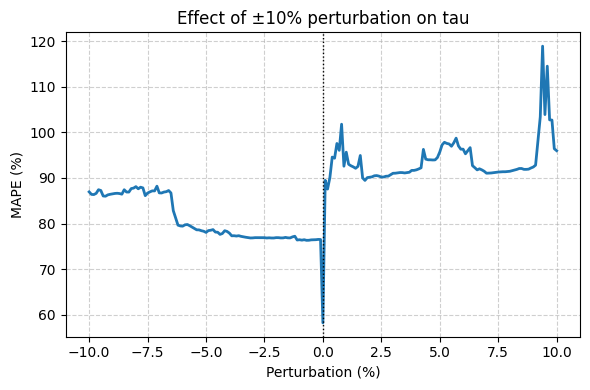


=== Perturbing K ===


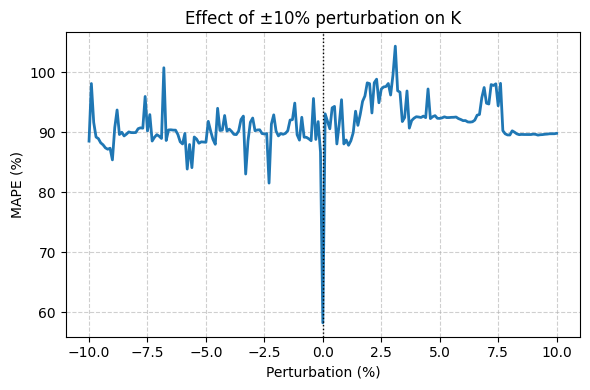


=== Perturbing eta_high ===


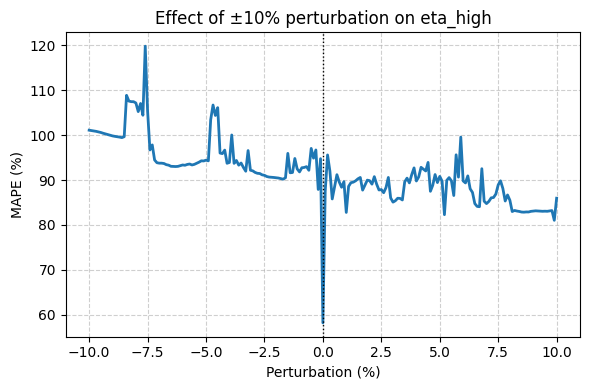


=== Perturbing p_crit ===


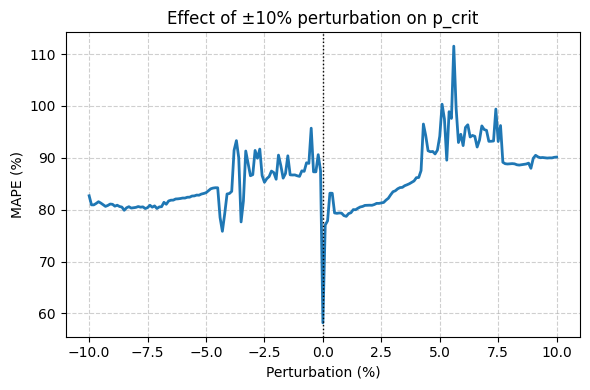


=== Perturbing v_free ===


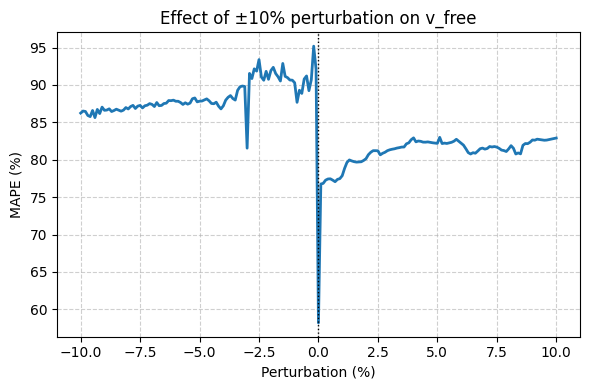


=== Perturbing a ===


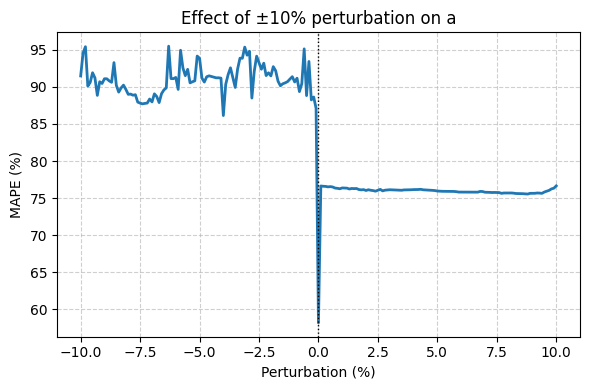


=== Perturbing downstream_density ===


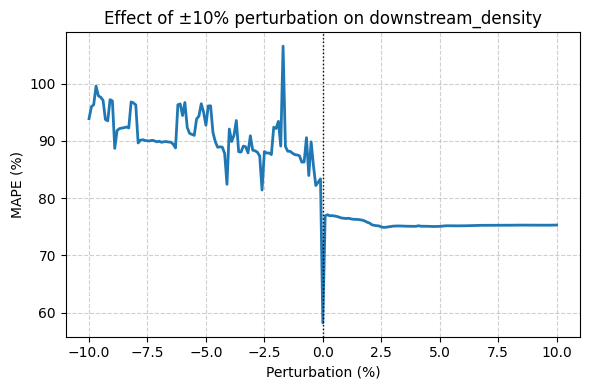


=== Perturbing data_inflow ===


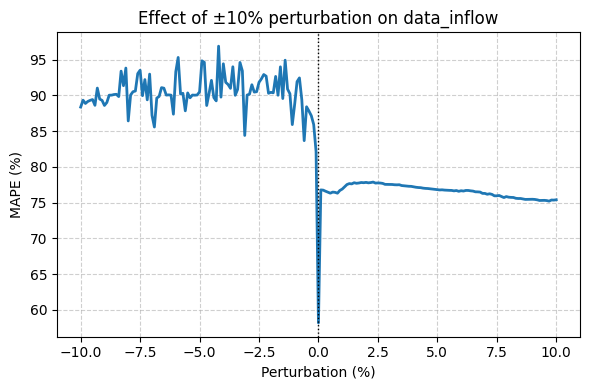

In [11]:
mape_results = perturb_and_plot_mape(params, rho_hat, q_hat, v_hat, num_lanes_array)
